In [426]:
import os
import numpy as np
import pandas as pd
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.distributions as distributions
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [427]:
# reading a single csv into a pytorch tensor
df = pd.read_csv("motionSense/A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_10.csv")
df.head()
features = list(df.columns)[1:]
print("features: ",features)
array = df.to_numpy()
print("array shape: ", array.shape)
clipped = array[:,1:]
print("clipped shape: ",clipped.shape)
p = torch.tensor(clipped)
print("tensor shape: ", p.shape)

features:  ['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y', 'rotationRate.z', 'userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']
array shape:  (2678, 13)
clipped shape:  (2678, 12)
tensor shape:  torch.Size([2678, 12])


In [428]:
def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("motionSense/data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss

def create_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'motionSense/A_DeviceMotion_data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data

print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 6 # dws, ups, wlk, jog, sit, std
num_gen_labels = 1 # 0/1(female/male)
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    
## Calling 'create_time_series()' to build time-series
print("--> Building Training and Test Datasets...")
train_ts, test_ts = create_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)
print("--> Shape of Training Time-Series:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Start...
--> Building Training and Test Datasets...
----> Data subjects information is imported.
--> Shape of Training Time-Series: (1082373, 19)
--> Shape of Test Time-Series: (331419, 19)


In [446]:
def get_tensors(dataset, num_channels=12, num_frames=5, num_labels=6):
    input_sz = num_frames*num_channels
    x = torch.tensor(dataset[:,:num_channels]).float()
    y = torch.tensor(dataset[:,num_channels:num_channels + num_labels]).float()
    classes, data, labels, new_data = [], [], [], []
    for i in range(6):
        new_class = train_ts[np.where(train_ts[:,num_channels + i])]
        classes.append(new_class)
        data.append(classes[i][:,:num_channels])
        labels.append(classes[i][:,num_channels + 1:])
        # crop & reshape data
        data[i] = data[i][:data[i].shape[0] - data[i].shape[0] % num_frames,:]
        new_data.append(data[i].reshape(-1,input_sz).astype(float))
        # optional: format as regression
        new_data[i] = np.array([np.append(new_data[i][j],i) for j in range(len(new_data[i]))])
    arr = np.array(np.concatenate(new_data, axis=0))
    x = arr[:,:-1]
    y = arr[:,-1:]
    x = torch.tensor(x).float()
    y = torch.tensor(y).float()
    print("Shape of data: ", x.shape)
    print("Shape of labels: ", y.shape)
    return x, y

In [429]:
x = torch.tensor(train_ts[:,:12]).float()
print("Shape of train data: ", x.shape)
y = torch.tensor(train_ts[:,12:18]).float()
print("Shape of train labels: ", y.shape)
print("labels 0: ", y[0])

Shape of train data:  torch.Size([1082373, 12])
Shape of train labels:  torch.Size([1082373, 6])
labels 0:  tensor([1., 0., 0., 0., 0., 0.])


In [430]:
classes = []
total_samples = 0
for i in range(6):
    new_class = train_ts[np.where(train_ts[:,12 + i])]
    print("class ", i, " shape: ", new_class.shape)
    classes.append(new_class)
    total_samples += len(new_class)
print("num classes: ", np.shape(classes))
print("num samples: ", total_samples)

class  0  shape:  (110281, 19)
class  1  shape:  (129276, 19)
class  2  shape:  (279016, 19)
class  3  shape:  (104327, 19)
class  4  shape:  (234657, 19)
class  5  shape:  (224816, 19)
num classes:  (6,)
num samples:  1082373


/Users/matthew/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [431]:
data = []
labels = []
for i in range(6):
    data.append(classes[i][:,:12])
    labels.append(classes[i][:,13:])
    print(data[i].shape)

(110281, 12)
(129276, 12)
(279016, 12)
(104327, 12)
(234657, 12)
(224816, 12)


In [432]:
num_frames = 5
input_sz = num_frames*12
new_data = []
for i in range(6):
    print("class ", i)
    print(data[i].shape)
    data[i] = data[i][:data[i].shape[0] - data[i].shape[0] % num_frames,:]
    new_data.append(data[i].reshape(-1,input_sz).astype(float))
    print(new_data[i].shape)

class  0
(110281, 12)
(22056, 60)
class  1
(129276, 12)
(25855, 60)
class  2
(279016, 12)
(55803, 60)
class  3
(104327, 12)
(20865, 60)
class  4
(234657, 12)
(46931, 60)
class  5
(224816, 12)
(44963, 60)


In [433]:
# format as regression problem
for i in range(6):
    print(len(new_data[i]))
    new_data[i] = np.array([np.append(new_data[i][j],i) for j in range(len(new_data[i]))])
    print(new_data[i].shape)

22056
(22056, 61)
25855
(25855, 61)
55803
(55803, 61)
20865
(20865, 61)
46931
(46931, 61)
44963
(44963, 61)


In [434]:
arr = np.array(np.concatenate(new_data, axis=0))
print(arr.shape)
x = arr[:,:-1]
y = arr[:,-1:]
print(x.shape)
print(y.shape)

(216473, 61)
(216473, 60)
(216473, 1)


In [435]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.norm = nn.BatchNorm1d(input_size)
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.norm(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [436]:
"""
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
"""

'\nclass Net(nn.Module):\n    def __init__(self, input_size, output_size):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv1d(input_size, 32, 3, 1)\n        self.conv2 = nn.Conv2d(32, 64, 3, 1)\n        self.dropout1 = nn.Dropout(0.25)\n        self.dropout2 = nn.Dropout(0.5)\n        self.fc1 = nn.Linear(9216, 128)\n        self.fc2 = nn.Linear(128, output_size)\n\n    def forward(self, x):\n        x = self.conv1(x)\n        x = F.relu(x)\n        x = self.conv2(x)\n        x = F.relu(x)\n        x = F.max_pool2d(x, 2)\n        x = self.dropout1(x)\n        x = torch.flatten(x, 1)\n        x = self.fc1(x)\n        x = F.relu(x)\n        x = self.dropout2(x)\n        x = self.fc2(x)\n        output = F.log_softmax(x, dim=1)\n        return output\n'

In [437]:
# 5 step input, 12 values. 6 class labels
output_sz = 1
net = Net(input_size=input_sz, output_size=output_sz)
print(net)

Net(
  (norm): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=60, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [438]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
net = net.to(device)

optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
losses = []

Using device: cpu


In [439]:
y_target = torch.tensor(y).float()
x = torch.tensor(x).float()
y_target = y_target.to(device)

In [440]:
def plot(xs, ys, xlim=(-3, 3), ylim=(-1, 12)):
  fig, ax = plt.subplots()
  ax.plot(xs, ys, linewidth=5)
  # ax.set_aspect('equal')
  ax.grid(True, which='both')
  
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_xlim(*xlim)
  ax.set_ylim(*ylim)

Final loss:  1.51152


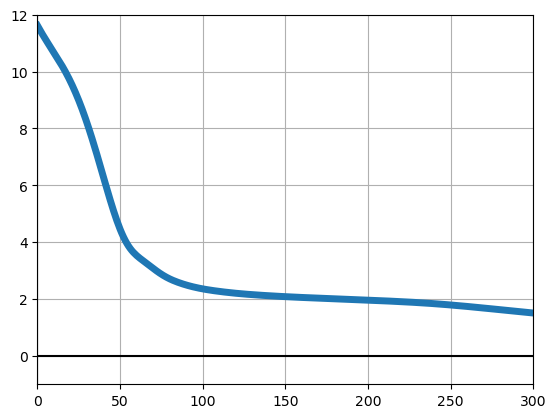

In [441]:
for _ in range(300):
    x = x.to(device)
    y = net(x)
    loss = loss_fn(y, y_target)
    losses.append(loss.detach().cpu().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Final loss: ", losses[-1])
plot(range(300), losses, xlim=(0, 300))

In [444]:
# validation
x = torch.tensor(test_ts[:,:12]).float()
print("Shape of test data: ", x.shape)
y = torch.tensor(test_ts[:,12:18]).float()
print("Shape of test labels: ", y.shape)
print("labels 0: ", y[0])

Shape of test data:  torch.Size([331419, 12])
Shape of test labels:  torch.Size([331419, 6])
labels 0:  tensor([1., 0., 0., 0., 0., 0.])
